### Data Loading

In [1]:
import pandas as pd
from helpers import *

Firstly, let's create our data-frame from our source data. Additionally, we'll transform the `Score_home` and `Score_away` columns into our target variable such that:
$$
y = \cases{-1 \\ 
            0 \\
            1 }
$$
using the helper function `score_to_win()`

In [2]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,target
0,5937,Blackburn,Reading,3,3,54.0,46.0,6,4,15,...,2007,18.84,21,19.28,25,10.52,25,0.00,19,0
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2,2,11,...,2007,19.38,16,4.39,16,28.16,17,2.08,18,0
2,5939,Chelsea,Everton,1,1,59.3,40.7,7,6,20,...,2007,101.43,23,59.96,22,20.41,11,2.85,16,0
3,5940,Liverpool,Charlton,2,2,61.6,38.4,5,4,23,...,2007,52.44,27,23.94,28,24.68,31,2.59,36,0
4,5941,Man Utd,West Ham,0,1,65.3,34.7,7,2,30,...,2007,31.01,25,20.52,29,79.63,22,7.70,23,-1


### Feature Extraction
Now, we must drop several variables from the above table in order to fit our model. We'll create `df_wo` to pass in. This leaves us with 24 avaiable features.

In [3]:
df_wo = df.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away'])
list(df_wo)

['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'year',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away']

## EDA
### Correlation

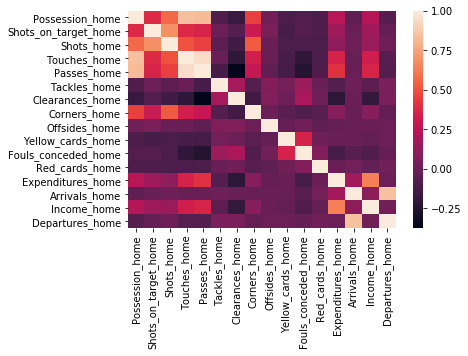

In [5]:
import seaborn as sns
home_features = [ f for f in list(df_wo) if '_home' in f ]
corr = df_wo[home_features].corr()
_ = sns.heatmap(corr)

### Variance Inflation
It is likely the case that several of the above variables are collinear. Now, in many models this might not have an effect as the coefficients for one variable will be high while the other will just be nullified. However, based on our correlation analysis it is clear some variables are capturing the same information. For example, possession is highly correlated with touches and passes. This isn't surprising, if a team possesses the ball for long stretches they are likely moving the ball around. 

So, we'll use the concept of << Math >>

We can use `statsmodels.stats.outliers_influence.variance_inflation_factor` to perform this analysis in Python.

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vifs = []
for i, feature in enumerate(list(df_wo)):
    vif_tup = (feature, variance_inflation_factor(df_wo.values, i))
    vifs.append( vif_tup )
print(vifs)

[('Possession_home', 486.0653996444629), ('Possession_away', 478.0328899411991), ('Shots_on_target_home', 8.88341265540607), ('Shots_on_target_away', 7.44168876563491), ('Shots_home', 22.520164579526792), ('Shots_away', 18.837895777430745), ('Touches_home', 1679.5868063725009), ('Touches_away', 1632.2906991231423), ('Passes_home', 866.9410901360411), ('Passes_away', 832.1493938696634), ('Tackles_home', 14.499726912477108), ('Tackles_away', 14.868821469217474), ('Clearances_home', 12.486482125524923), ('Clearances_away', 14.771748005823655), ('Corners_home', 7.930518365609224), ('Corners_away', 6.518106128720305), ('Offsides_home', 2.770243990163692), ('Offsides_away', 2.6080052683540442), ('Yellow_cards_home', 3.0290136017221236), ('Yellow_cards_away', 3.5663123325777972), ('Fouls_conceded_home', 14.667173510941652), ('Fouls_conceded_away', 14.920239062362345), ('Red_cards_home', 1.1172333137334791), ('Red_cards_away', 1.1466701514616544), ('year', 234.17375577037453), ('Expenditures_h

## Feature Engineering
### Form
Often, in the sport, commentators and analysts point to a team's form (essentially the recent performance) as being somewhat important in their performance in an individual game. The thinking goes: if this team has played well, they will continue to play well. It is not dissimilar to the concept of momentum, in a way. 
<< Math >>

In [7]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_linear = []
home_form_linear = []
away_form_exp = []
home_form_exp = []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )
    away_form_linear.append( linear_momentum(id, away_team, gd) )
    home_form_linear.append( linear_momentum(id, home_team, gd) )


df_form = df_wo.copy()
df_form['away_form_linear'] = pd.Series(away_form_linear)
df_form['home_form_linear'] = pd.Series(home_form_linear)
df_form['away_form_exp'] = pd.Series(away_form_exp)
df_form['home_form_exp'] = pd.Series(home_form_exp)
list(df_form)

['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'year',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away',
 'away_form_linear',
 'home_form_linear',
 'away_form_exp',
 'home_form_exp']

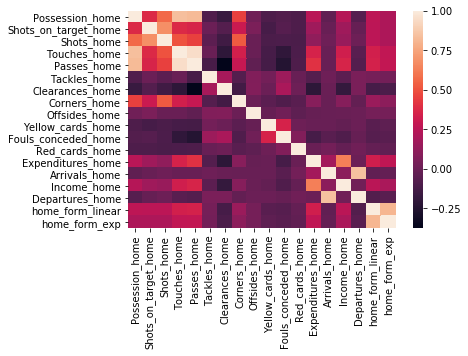

In [8]:
home_features = [ f for f in list(df_form) if 'home' in f ]
corr = df_form[home_features].corr()
_ = sns.heatmap(corr)

## Feature Selection/Extraction

### Assessing feature importance with random forests

In [9]:
df_wo.head()

,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,Shots_away,Touches_home,Touches_away,Passes_home,Passes_away,...,Red_cards_away,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away
0,54.0,46.0,6,4,15,11,553,464,356,287,...,0,2007,18.84,21,19.28,25,10.52,25,0.00,19
1,47.1,52.9,2,2,11,7,457,493,318,343,...,0,2007,19.38,16,4.39,16,28.16,17,2.08,18
2,59.3,40.7,7,6,20,11,615,471,425,305,...,0,2007,101.43,23,59.96,22,20.41,11,2.85,16
3,61.6,38.4,5,4,23,9,632,420,453,271,...,0,2007,52.44,27,23.94,28,24.68,31,2.59,36
4,65.3,34.7,7,2,30,8,825,506,619,333,...,0,2007,31.01,25,20.52,29,79.63,22,7.70,23


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_wo.values
y = df['target'].values
features = df_wo.columns
forest = RandomForestClassifier(n_estimators=500,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                                random_state = 42)

forest.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) Shots_on_target_home           0.071977
 2) Shots_on_target_away           0.064050
 3) Clearances_away                0.060091
 4) Clearances_home                0.050541
 5) Expenditures_home              0.036953
 6) Expenditures_away              0.036937
 7) Passes_away                    0.035908
 8) Passes_home                    0.035453
 9) Touches_away                   0.034935
10) Income_away                    0.034511
11) Touches_home                   0.032524
12) Income_home                    0.032445
13) Shots_away                     0.030705
14) Shots_home                     0.030670
15) Tackles_away                   0.029061
16) Possession_home                0.028453
17) Possession_away                0.028400
18) Tackles_home                   0.028019
19) Arrivals_away                  0.027298
20) Departures_away                0.026721
21) Departures_home                0.026153
22) Arrivals_home                  0.026120
23) Fouls_conceded_away         

### Feature selection with Sequential Backward Selection (SBS)

In [13]:
from SBS import *

In [15]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train, y_train)

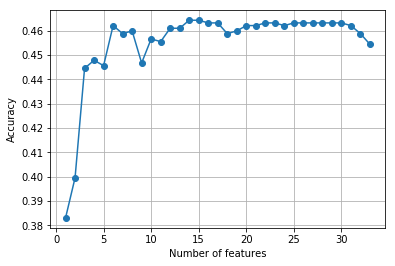

In [16]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
#plt.ylim([0.3, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

With KNN, the least number of features that has the best accuracy is 14. They are identified as:

In [17]:
k14 = list(sbs.subsets_[19])
for idx, i in enumerate(k14):
    print(idx,features[i])

0 Touches_home
1 Touches_away
2 Passes_home
3 Passes_away
4 Clearances_away
5 Fouls_conceded_away
6 Expenditures_home
7 Arrivals_home
8 Income_home
9 Departures_home
10 Expenditures_away
11 Arrivals_away
12 Income_away
13 Departures_away


#### Checking the performance of the selected features
It seems like using the selected features can improve test accuracy for KNN classifier

In [18]:
knn.fit(X_train, y_train)
print('Training accuracy:', knn.score(X_train, y_train))
print('Test accuracy:', knn.score(X_test, y_test))

Training accuracy: 0.634742041712404
Test accuracy: 0.4583333333333333


In [19]:
knn.fit(X_train[:, k14], y_train)
print('Training accuracy:', knn.score(X_train[:, k14], y_train))
print('Test accuracy:', knn.score(X_train[:, k14], y_train))

Training accuracy: 0.6309001097694841
Test accuracy: 0.6309001097694841


### Feature extraction with PCA

In [20]:
from PlotDecisionRegions import *

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [23]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([1.92365738e-01, 1.01847316e-01, 6.17349350e-02, 5.90731716e-02,
       5.63889391e-02, 4.89937392e-02, 3.99217670e-02, 3.75389709e-02,
       3.47937305e-02, 3.28452200e-02, 3.19716300e-02, 3.09245616e-02,
       2.95991258e-02, 2.76748713e-02, 2.61994774e-02, 2.41794810e-02,
       2.10571606e-02, 2.00634511e-02, 1.79093922e-02, 1.67850906e-02,
       1.51713887e-02, 1.27007357e-02, 1.20864463e-02, 1.09779651e-02,
       9.88015205e-03, 7.87694844e-03, 7.44369955e-03, 3.88742932e-03,
       3.83036064e-03, 2.50831363e-03, 1.07679495e-03, 5.38443193e-04,
       1.53553289e-04])

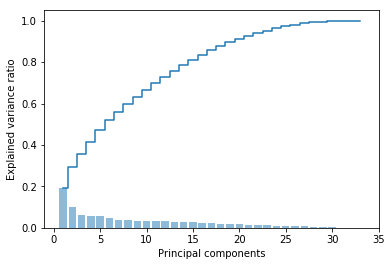

In [25]:
plt.bar(range(1, 34), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 34), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
lr.fit(X_train_pca, y_train)
# plot_decision_regions(X_train_pca, y_train, classifier=lr)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.legend(loc='lower left')
# plt.show()

### Feature extraction with LDA

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
# plot_decision_regions(X_train_lda, y_train, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# # plt.savefig('./images/lda3.png', dpi=300)
# plt.show()

### Feature extraction with KPCA

In [28]:
from sklearn.decomposition import KernelPCA
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

X_skernpca = scikit_kpca.fit_transform(X)

# plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
#             color='red', marker='^', alpha=0.5)
# plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
#             color='blue', marker='o', alpha=0.5)

# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.tight_layout()
# # plt.savefig('./figures/scikit_kpca.png', dpi=300)
# plt.show()

## Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [ ]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier()]

In [ ]:
X = df_wo.values
df_form.drop(columns = ['home_form_linear', 'away_form_linear'], inplace = True)
X_form = df_form.values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
X_train_form, X_test_form, y_train_form, y_test_form = train_test_split(X_form, y, test_size = .2)

In [ ]:
for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

In [ ]:
for clf in clfs:
    clf.fit(X_train_form, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form, y_test_form), "\n")

### Coefficient Investigation

In [ ]:
# change to clfs[i]
for i, feature in enumerate(list(df_wo)):
    print(feature, ": ", lr.coef_[:,i])

### Variance Inflation

### Pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X= X_train, y = y_train, cv = 10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
                'svc__kernel': ['linear']},
            {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)                         

In [ ]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

>>> scores = cross_val_score(gs, X_train, y_train,
...                          scoring='accuracy', cv=5)
>>> print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
...                                       np.std(scores)))
CV accuracy: 0.934 +/- 0.016